In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
import matplotlib.gridspec as gridspec
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Camera Calibration 

In [2]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

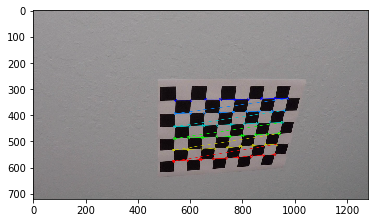

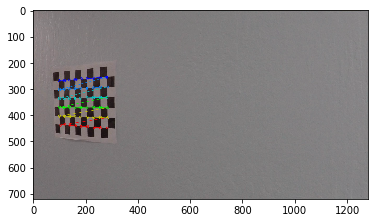

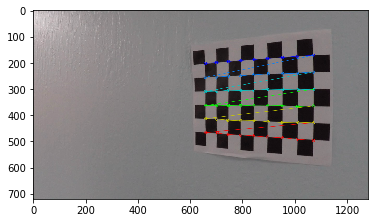

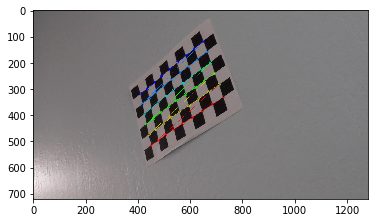

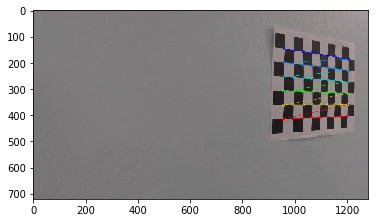

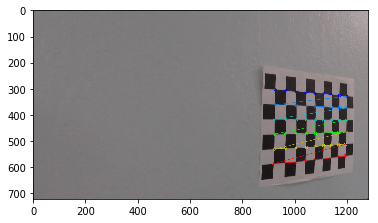

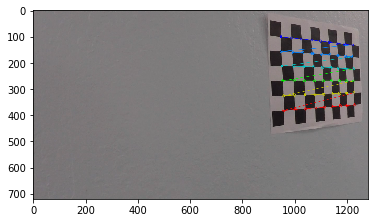

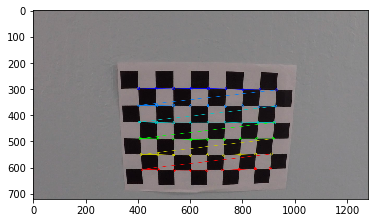

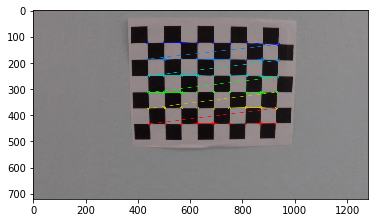

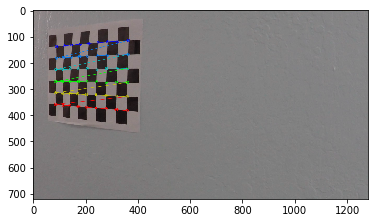

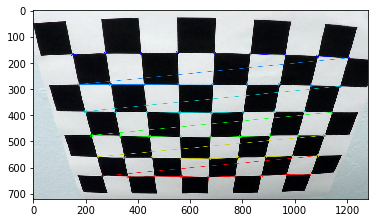

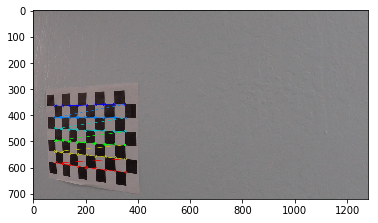

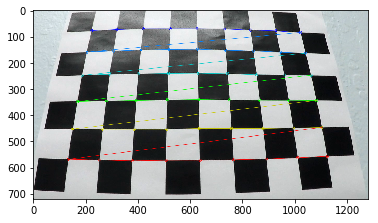

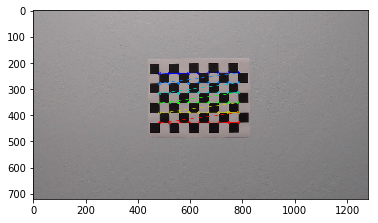

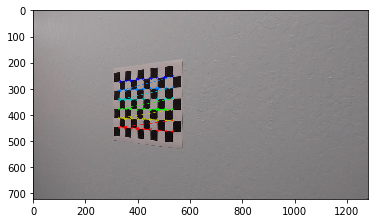

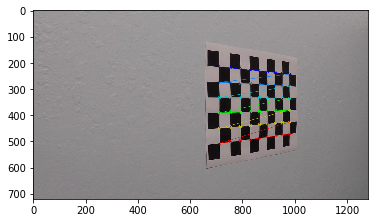

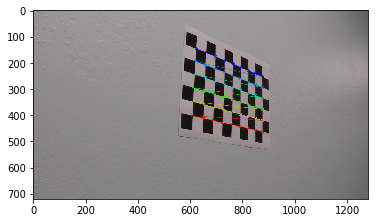

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)
        
# Calibrating Camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### Take a look at the undistorted images using one of the calibration images

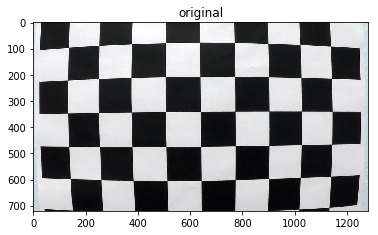

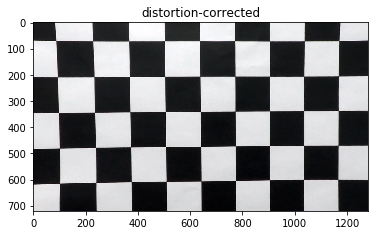

In [4]:
img = cv2.imread(images[0])
plt.figure()
plt.imshow(img)
plt.title("original")
plt.figure()
plt.imshow(cv2.undistort(img,  mtx, dist, None, mtx))
plt.title("distortion-corrected")

### Take a look at the undistorted images using one of the test images

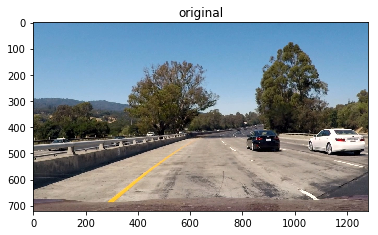

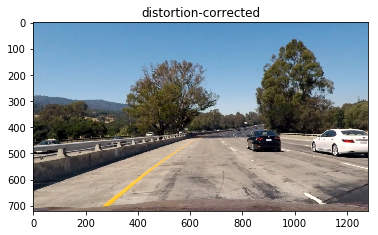

In [5]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.figure()
plt.imshow(img)
plt.title("original")
plt.figure()
plt.imshow(cv2.undistort(img,  mtx, dist, None, mtx))
plt.title("distortion-corrected")

### Save the matrix

In [6]:
with open('src/mtx.pkl', 'wb') as handle:
    pickle.dump(mtx, handle)
    
with open('src/dist.pkl', 'wb') as handle:
    pickle.dump(dist, handle)

## Thresholded binary image

In [7]:
# pipeline, single images
def pipeline(img, s_thresh=(170, 255), sx_thresh=(30, 150)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the l & s channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold HLS color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    final_result = np.zeros_like(sxbinary)
    final_result[(sxbinary == 1) |(s_binary ==1)] =1

    return color_binary, final_result

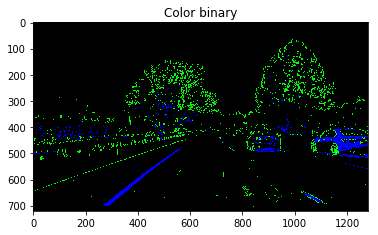

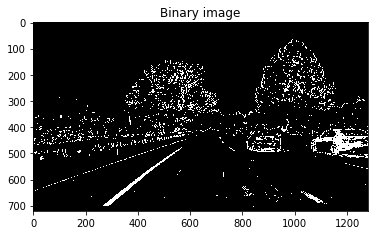

In [8]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
color_binary,final_result = pipeline(cv2.undistort(img,  mtx, dist, None, mtx))

plt.figure()
plt.imshow(color_binary)
plt.title('Color binary')
plt.figure()
plt.imshow(final_result, cmap='gray')
plt.title('Binary image')


# Perspective transform

In [9]:
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped

In [10]:
SRC_COORDS=np.float32([(203,720),(1127,720),(695,460),(585,460)])
DEST_COORDS=np.float32([(320,720),(960,720),(960,0),(320,0)])

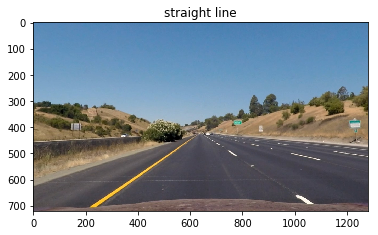

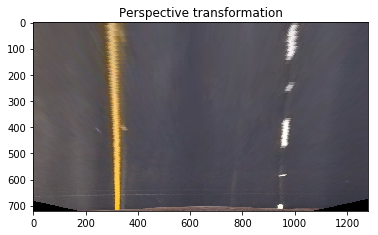

In [11]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
img = cv2.undistort(img,  mtx, dist, None, mtx)
img_warped = warper(img, SRC_COORDS, DEST_COORDS)

plt.figure()
plt.imshow(img)
plt.title("straight line")

plt.figure()
plt.imshow(img_warped)
plt.title("Perspective transformation")


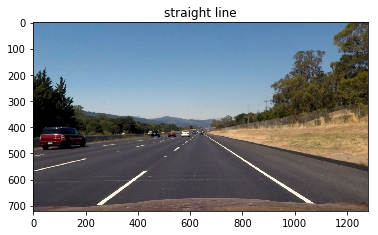

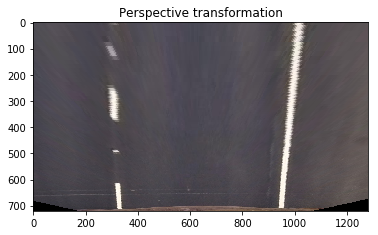

In [12]:
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.undistort(img,  mtx, dist, None, mtx)
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
img_warped = warper(img, SRC_COORDS, DEST_COORDS)

plt.figure()
plt.imshow(img)
plt.title("straight line")

plt.figure()
plt.imshow(img_warped)
plt.title("Perspective transformation")


# Video Stream

### Declaring Parameters

In [13]:
from codes.Line import Line

In [ ]:
# External Function called
def process_image(image):
    resulting_image= lines.iter_once(image)
    #result = image
    return resulting_image

challenge_output = 'result.mp4'
clip2 = VideoFileClip('project_video.mp4')
lines = Line()
challenge_clip = clip2.fl_image(lambda image:  lines.iter_once(image))
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 88%|████████▊ | 1115/1261 [02:25<00:17,  8.35it/s]

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

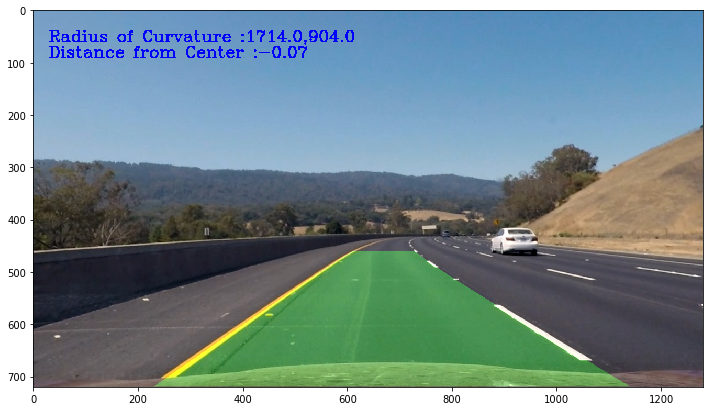

In [16]:
lines = Line()
img = process_image(plt.imread('test_images/test3.jpg'))
plt.figure(figsize=(12,8))
plt.imshow(img)